<a href="https://colab.research.google.com/github/shivam-pandey-15/Generative-Models/blob/master/PyTorch/WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

from matplotlib import pyplot as plt
from IPython import display
%load_ext autoreload
%autoreload 2

In [0]:
#Used fashion mnist dataset
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])
        ])
mnist = datasets.MNIST(root='./mnist', train=True, transform=transform, download=True)
mnist.data.shape


0it [00:00, ?it/s]

9920512it [00:02, 4110235.79it/s]                             


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 68193.20it/s]                            
0it [00:00, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 1176983.73it/s]                            
0it [00:00, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 25794.42it/s]            

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


torch.Size([60000, 28, 28])

In [0]:

Epoch = 1000
CUDA = torch.cuda.is_available()
batch_size = 128
data_loader = torch.utils.data.DataLoader(mnist, batch_size=batch_size, shuffle=True)

In [0]:
CUDA

True

In [0]:
class Discriminator(torch.nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    in_features = 784
    hidden1 = 256
    hidden2 = 256
    out_features = 1
    
    
    self.hid1 = nn.Sequential(nn.Linear(in_features,hidden1), nn.ReLU(),nn.Dropout(0.1))
    self.hid2 = nn.Sequential(nn.Linear(hidden1,hidden2), nn.ReLU(),nn.Dropout(0.1))
    self.out  = nn.Sequential(nn.Linear(hidden2,out_features), nn.Sigmoid())
    
  def forward(self,x):
    x = self.hid1(x)
    x = self.hid2(x)
    x = self.out(x)
    return x

In [0]:

class Generator(torch.nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        in_features = 100
        hidden1 = 256
        hidden2 = 256
        out_features = 784
        
        self.hid1 = nn.Sequential(nn.Linear(in_features,hidden1), nn.ReLU(),nn.Dropout(0.1))
        self.hid2 = nn.Sequential(nn.Linear(hidden1,hidden2), nn.ReLU(),nn.Dropout(0.1))
        self.out  = nn.Sequential(nn.Linear(hidden2,out_features), nn.Tanh())

    def forward(self, x):
        x = self.hid1(x)
        x = self.hid2(x)
        x = self.out(x)
        return x
      
    def image(self,size):
        n = Variable(torch.randn(size, 100))
        if CUDA:
          n = n.cuda()
        return self.forward(n)
        

In [0]:
generator = Generator()
discriminator = Discriminator()
if CUDA:
    discriminator.cuda()
    generator.cuda()
   

In [0]:
d_optimizer = optim.RMSprop(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.RMSprop(generator.parameters(), lr=0.001)


In [0]:
def discriminator_train(real,fake,clip_value=0.01):
  
  real_label = Variable(torch.ones(real.shape[0])).cuda() if CUDA else Variable(torch.ones(real.shape[0]))
  fake_label = Variable(torch.zeros(real.shape[0])).cuda() if CUDA else Variable(torch.zeros(real.shape[0]))
  
  d_optimizer.zero_grad()
  
  real_predict = discriminator(real)
  fake_predict = discriminator(fake)
  
  delta =-torch.mean(real_predict) + torch.mean(fake_predict)
  delta.backward()
  
  d_optimizer.step()
  for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)

  
  return real_predict , fake_predict , delta

def generator_train(fake):
  
  fake_label = Variable(torch.ones(fake.shape[0])).cuda() if CUDA else Variable(torch.ones(fake.shape[0]))
  g_optimizer.zero_grad()
  
  predict = discriminator(fake)
  delta = -torch.mean(predict)
  delta.backward()
  
  g_optimizer.step()
  
  return predict , delta
    

In [0]:
def plot_images(epoch=0):
  images = generator.image(16)
  images = images.view(images.size(0), 1, 28, 28)
  figure = plt.figure()
  num_of_images = 16
  for index in range(1, num_of_images + 1):
      plt.subplot(4, 4, index)
      plt.axis('off')
      plt.imshow(images[index-1].cpu().detach().numpy().squeeze(), cmap='gray')
  if epoch%10 == 0 and epoch!= 0:
    plt.savefig('Epoch_{:04d}.png'.format(epoch)) 
  plt.show()

Epoch:231 [468/469] DError:-8.344650268554688e-07 GError:-0.5025012493133545


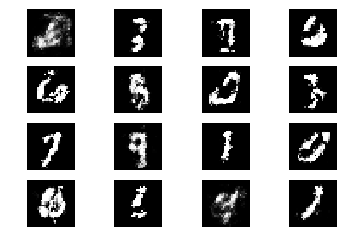

In [0]:
for epoch in range(Epoch):
  
  for batch , (train_data , label ) in enumerate(data_loader):
    train_data = train_data.view(train_data.size(0), 784)
    real = train_data.cuda() if CUDA else train_data
    fake = generator.image(real.shape[0]).detach()
    real_predict , fake_predict , derror = discriminator_train(real,fake) 
    
    fake = generator.image(real.shape[0])
    if batch%5==0:
      generator_predict , gerror = generator_train(fake)
    
  display.clear_output(True)  
  print("Epoch:{} [{}/{}] DError:{} GError:{}".format(epoch,batch,len(data_loader), derror.mean(),gerror.mean() ))
  plot_images()
    
    

